In [ ]:
!pip install -r requirements.txt
!pip install mne_connectivity --no-deps
!pip install xarray

In [33]:
# Manipulation de données
import pandas as pd
import numpy as np

# Traitement du signal
from scipy import signal
import mne

# Machine Learning et Deep Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch


# Visualisation
import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px

# Gestion de Notebooks
#import papermill as pm
import ipywidgets as widgets

# Utilitaires
import joblib
import yaml
import pickle
import os
import sys
import importlib

# Importation code local
sys.path.append('preprocessing')
import preprocess
import dataset
import noise
import torchcam
import models.GGN.ggn_model as GGN
import models.GGN.train as train
import models.EEGNet.EEGNet as EEGNet
import models.EEGDeformer.EEGDeformer as EEGDeformer
sys.path.append('evaluation')
import within_session
import noise
import saliency_map
from preprocessing.preprocess import train_test_split_files
importlib.reload(preprocess)
importlib.reload(GGN)
importlib.reload(train)
importlib.reload(dataset)
importlib.reload(within_session)
importlib.reload(noise)
importlib.reload(saliency_map)


<module 'saliency_map' from '/project/166600089/master/evaluation/saliency_map.py'>

## Chargement de la configuration du projet

In [32]:
# Chargement de la configuration YAML
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)
    
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Appliquer le seed depuis la config
set_seed(config['project_config']['seed'])
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing

In [ ]:
base_dir = os.path.join(os.getcwd(), "data/processed")
output_dir = os.path.join(os.getcwd(), "data/noisy")
path_noisy = "data/noisy"
path_split = "data/split_noisy"

subjects_id = config['data']['subjects']

preprocess.preprocess_data(config)
noise.process_and_save_noisy_data(base_dir, output_dir, subjects_id, 0.01, 0.0005)
preprocess.train_test_split_files(subjects_id, path_noisy, path_split, 0.2, 42)

## Model Training (Without noise)

In [34]:
running_model = config['project_config']['running_model']

subjects_id = config['data']['subjects']

bids_root = config['data']['path']

result_save_path = config['output']['results_save_path']

test_losses = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
auc_rocs = []

if not subjects_id:
        subjects_id = [
            d for d in os.listdir(bids_root)
            if os.path.isdir(os.path.join(bids_root, d)) and d.startswith("sub-")
        ]
        print(f"Aucun ID de sujet spécifié. Tous les sujets détectés : {subjects_id}")

for subject in subjects_id:

    if running_model == "GGN":
        raw_data = mne.io.read_raw_brainvision(
            os.path.join(bids_root, subject, "eeg", f"{subject}_task-{config['data']['tasks'][0]}_eeg.vhdr"),
            eog=["VEOG", "HEOG"],
            misc=["rating", "temp", "stim"],
            preload=True,
        )
        if 'Iz' in raw_data.ch_names:
            raw_data.drop_channels(["Iz"])

        montage = mne.channels.make_standard_montage('standard_1020')
        raw_data.set_montage(montage)
        coords = np.array([
            ch['loc'][:3] for ch in raw_data.info['chs']
            if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and np.any(ch['loc'][:3])
        ])
        info = raw_data.info

        train_loader, val_loader, test_loader = dataset.create_dataloader([subject], config)

        model = GGN.GGN(**config['models']['GGN']['parameters'], subject_id=subject, coords=coords, info=info,
                        save_path=result_save_path)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 50

        # Train and validate the model
        train.train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

        # Test the model
        avg_test_loss, accuracy, recall, precision, f1, auc_roc = train.test(model, test_loader, criterion, device)
        test_losses.append(avg_test_loss)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1_scores.append(f1)
        auc_rocs.append(auc_roc)
        
        model.explain_temporal_cnn(test_loader, device)
        

    elif running_model == "SVM":
        train_loader, val_loader, test_loader = dataset.create_dataloader([subject], config)

        # Convert data loaders to numpy arrays
        X_train, y_train = preprocess.dataloader_without_topology_to_numpy(train_loader)
        X_val, y_val = preprocess.dataloader_without_topology_to_numpy(val_loader)
        X_test, y_test = preprocess.dataloader_without_topology_to_numpy(test_loader)
        
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

        # Reshape data
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        # Train the SVM
        svm_params = config['models']['SVM']['parameters']
        svm = SVC(**svm_params)
        svm.fit(X_train, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Test the model
        y_test_pred = svm.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        accuracies.append(test_acc)

    elif running_model == "EEGNet":
        model = EEGNet.EEGNet(nb_classes = 2).to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        within_session.within_session_evaluation(config, model, criterion, optimizer, device)
         
    elif running_model == "EEGDeformer":
        model = EEGDeformer.Deformer(num_chan=64, num_time=65, temporal_kernel=11, num_kernel=64,
                num_classes=2, depth=4, heads=8,
                mlp_dim=8, dim_head=8, dropout=0.).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        within_session.within_session_evaluation(config, model, criterion, optimizer, device)

# Calculate mean test accuracy across all subjects
mean_test_loss = np.mean(test_losses)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
mean_precision = np.mean(precisions)
mean_f1 = np.mean(f1_scores)
mean_auc_roc = np.mean(auc_rocs)

print(f"Mean Test Loss across all subjects: {mean_test_loss:.4f}")
print(f"Mean Test Accuracy across all subjects: {mean_accuracy:.2f}%")
print(f"Mean Recall (Sensitivity) across all subjects: {mean_recall:.2f}")
print(f"Mean Precision across all subjects: {mean_precision:.2f}")
print(f"Mean F1 Score across all subjects: {mean_f1:.2f}")
print(f"Mean AUC-ROC across all subjects: {mean_auc_roc:.2f}")


Processing subject: sub-002
Epoch 1/2
  Train Loss: 0.6273 | Train Accuracy: 0.6599
  Val Loss: 0.8856   | Val Accuracy: 0.5000
Epoch 2/2
  Train Loss: 0.5102 | Train Accuracy: 0.7703
  Val Loss: 0.8190   | Val Accuracy: 0.5208
Model saved for subject sub-002: models/trained/subject_sub-002_model.pth
Plot saved for subject sub-002: Plots/subject_sub-002_plot.png
Processing subject: sub-003
Epoch 1/2
  Train Loss: 0.5579 | Train Accuracy: 0.7064
  Val Loss: 0.8031   | Val Accuracy: 0.5208
Epoch 2/2
  Train Loss: 0.4637 | Train Accuracy: 0.8052
  Val Loss: 0.6883   | Val Accuracy: 0.6042
Model saved for subject sub-003: models/trained/subject_sub-003_model.pth
Plot saved for subject sub-003: Plots/subject_sub-003_plot.png
Mean accuracy across all subjects: 0.60
Processing subject: sub-002
Epoch 1/2
  Train Loss: 0.6537 | Train Accuracy: 0.6395
  Val Loss: 1.2624   | Val Accuracy: 0.5000
Epoch 2/2
  Train Loss: 0.5233 | Train Accuracy: 0.7616
  Val Loss: 1.0099   | Val Accuracy: 0.5000
Mo

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2023a/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2023a/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
## Model Training (With noise)

In [35]:
running_model = config['project_config']['running_model']

subjects_id = config['data']['subjects']

bids_root = config['data']['path']

config['output']['split_data_save_path'] = path_split # Change to path with noisy data

result_save_path = config['output']['results_save_path']

test_losses = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
auc_rocs = []

if not subjects_id:
        subjects_id = [
            d for d in os.listdir(bids_root)
            if os.path.isdir(os.path.join(bids_root, d)) and d.startswith("sub-")
        ]
        print(f"Aucun ID de sujet spécifié. Tous les sujets détectés : {subjects_id}")

for subject in subjects_id:

    if running_model == "GGN":
        raw_data = mne.io.read_raw_brainvision(
            os.path.join(bids_root, subject, "eeg", f"{subject}_task-{config['data']['tasks'][0]}_eeg.vhdr"),
            eog=["VEOG", "HEOG"],
            misc=["rating", "temp", "stim"],
            preload=True,
        )
        if 'Iz' in raw_data.ch_names:
            raw_data.drop_channels(["Iz"])

        montage = mne.channels.make_standard_montage('standard_1020')
        raw_data.set_montage(montage)
        coords = np.array([
            ch['loc'][:3] for ch in raw_data.info['chs']
            if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and np.any(ch['loc'][:3])
        ])
        info = raw_data.info

        train_loader, val_loader, test_loader = dataset.create_dataloader([subject], config)

        model = GGN.GGN(**config['models']['GGN']['parameters'], subject_id=subject, coords=coords, info=info,
                        save_path=result_save_path)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 50

        # Train and validate the model
        train.train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

        # Test the model
        avg_test_loss, accuracy, recall, precision, f1, auc_roc = train.test(model, test_loader, criterion, device)
        test_losses.append(avg_test_loss)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1_scores.append(f1)
        auc_rocs.append(auc_roc)
        
        model.explain_temporal_cnn(test_loader, device)
        

    elif running_model == "SVM":
        train_loader, val_loader, test_loader = dataset.create_dataloader([subject], config)

        # Convert data loaders to numpy arrays
        X_train, y_train = preprocess.dataloader_without_topology_to_numpy(train_loader)
        X_val, y_val = preprocess.dataloader_without_topology_to_numpy(val_loader)
        X_test, y_test = preprocess.dataloader_without_topology_to_numpy(test_loader)
        
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

        # Reshape data
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        # Train the SVM
        svm_params = config['models']['SVM']['parameters']
        svm = SVC(**svm_params)
        svm.fit(X_train, y_train)

        # Evaluate on validation set
        y_val_pred = svm.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Test the model
        y_test_pred = svm.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        accuracies.append(test_acc)

    elif running_model == "EEGNet":
        model = EEGNet.EEGNet(nb_classes = 2).to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        within_session.within_session_evaluation(config, model, criterion, optimizer, device)
         
    elif running_model == "EEGDeformer":
        model = EEGDeformer.Deformer(num_chan=64, num_time=65, temporal_kernel=11, num_kernel=64,
                num_classes=2, depth=4, heads=8,
                mlp_dim=8, dim_head=8, dropout=0.).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        within_session.within_session_evaluation(config, model, criterion, optimizer, device)

# Calculate mean test accuracy across all subjects
mean_test_loss = np.mean(test_losses)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
mean_precision = np.mean(precisions)
mean_f1 = np.mean(f1_scores)
mean_auc_roc = np.mean(auc_rocs)

print(f"Mean Test Loss across all subjects: {mean_test_loss:.4f}")
print(f"Mean Test Accuracy across all subjects: {mean_accuracy:.2f}%")
print(f"Mean Recall (Sensitivity) across all subjects: {mean_recall:.2f}")
print(f"Mean Precision across all subjects: {mean_precision:.2f}")
print(f"Mean F1 Score across all subjects: {mean_f1:.2f}")
print(f"Mean AUC-ROC across all subjects: {mean_auc_roc:.2f}")


Processing subject: sub-002
Epoch 1/2
  Train Loss: 0.6826 | Train Accuracy: 0.5872
  Val Loss: 0.7216   | Val Accuracy: 0.5417
Epoch 2/2
  Train Loss: 0.5765 | Train Accuracy: 0.7297
  Val Loss: 0.6128   | Val Accuracy: 0.6667
Model saved for subject sub-002: models/trained/subject_sub-002_model.pth
Plot saved for subject sub-002: Plots/subject_sub-002_plot.png
Processing subject: sub-003
Epoch 1/2
  Train Loss: 0.6828 | Train Accuracy: 0.5785
  Val Loss: 0.6848   | Val Accuracy: 0.5833
Epoch 2/2
  Train Loss: 0.5865 | Train Accuracy: 0.7093
  Val Loss: 0.7056   | Val Accuracy: 0.5000
Model saved for subject sub-003: models/trained/subject_sub-003_model.pth
Plot saved for subject sub-003: Plots/subject_sub-003_plot.png
Mean accuracy across all subjects: 0.64
Processing subject: sub-002
Epoch 1/2
  Train Loss: 0.6787 | Train Accuracy: 0.5988
  Val Loss: 1.1775   | Val Accuracy: 0.5000
Epoch 2/2
  Train Loss: 0.5321 | Train Accuracy: 0.8110
  Val Loss: 0.8027   | Val Accuracy: 0.5208
Mo

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2023a/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2023a/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Répertoire des données traitées : /project/166600089/master/data/processed
Répertoire des données bruitées : /project/166600089/master/data/noisy
Répertoire des données split : /project/166600089/master/data/split_noisy


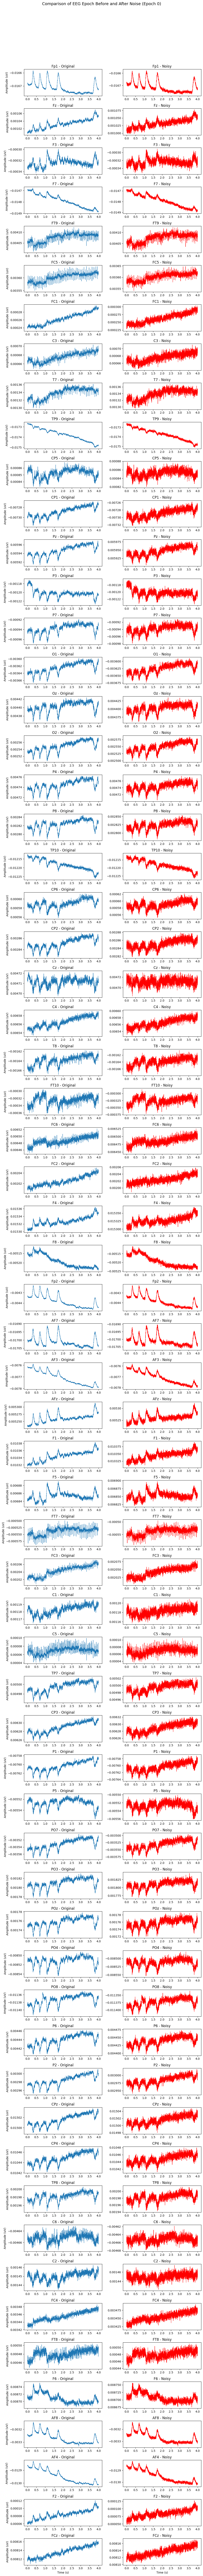

In [36]:
# Configuration
base_dir = os.path.join(os.getcwd(), "data/processed")  # Répertoire contenant les fichiers d'origine
output_dir = os.path.join(os.getcwd(), "data/noisy")   # Répertoire de sortie pour les fichiers bruités
split_dir = os.path.join(os.getcwd(), "data/split_noisy")  # Répertoire pour les fichiers bruités split

print("Répertoire des données traitées :", base_dir)
print("Répertoire des données bruitées :", output_dir)
print("Répertoire des données split :", split_dir)

# Visualisation d'un epoch avant et après le bruit
epoch_file_original = os.path.join(base_dir, "sub-003/audioactive/2-epo.fif")  # Ajuster si nécessaire
epoch_file_noisy = os.path.join(split_dir, "train/sub-003/audioactive/2-epo.fif")  # Ajuster selon l'organisation

def plot_epoch_comparison(original_file, noisy_file, epoch_idx=0):
    """
    Compare un epoch EEG avant et après l'ajout de bruit.

    Arguments :
    - original_file : str, chemin vers le fichier d'epochs original.
    - noisy_file : str, chemin vers le fichier d'epochs bruité.
    - epoch_idx : int, index de l'epoch à afficher.
    """
    # Charger les epochs
    epochs_original = mne.read_epochs(original_file, preload=True)
    epochs_noisy = mne.read_epochs(noisy_file, preload=True)
    
    data_original = epochs_original.get_data()[epoch_idx]
    data_noisy = epochs_noisy.get_data()[epoch_idx]
    
    ch_names = epochs_original.ch_names
    time_points = epochs_original.times

    # Affichage
    fig, axes = plt.subplots(len(ch_names), 2, figsize=(10, len(ch_names) * 2))
    fig.suptitle(f"Comparison of EEG Epoch Before and After Noise (Epoch {epoch_idx})", fontsize=14)
    
    for i, ch_name in enumerate(ch_names):
        # Original signal
        axes[i, 0].plot(time_points, data_original[i], linewidth=0.8)
        axes[i, 0].set_title(f"{ch_name} - Original")
        axes[i, 0].set_ylabel("Amplitude (uV)")
        
        # Noisy signal
        axes[i, 1].plot(time_points, data_noisy[i], linewidth=0.8, color='r')
        axes[i, 1].set_title(f"{ch_name} - Noisy")
    
    
    
    # Labels
    for ax in axes[-1]:
        ax.set_xlabel("Time (s)")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Appel de la fonction pour comparaison
plot_epoch_comparison(epoch_file_original, epoch_file_noisy, epoch_idx=0)
